In [5]:
import numpy as np
import pandas as pd
import yfinance as yf

ticker_symbol = "DX-Y.NYB"
ticker = yf.Ticker(ticker_symbol)
df = ticker.history(period="5y").reset_index(drop=False)
df = df.sort_values("Date")
df.drop(columns=["Volume", "Dividends", "Stock Splits"], inplace=True)
df.head()

,Date,Open,High,Low,Close
0,2020-11-04 00:00:00-05:00,93.089996,94.300003,93.089996,93.410004
1,2020-11-05 00:00:00-05:00,93.339996,93.550003,92.489998,92.529999
2,2020-11-06 00:00:00-05:00,92.570000,92.820000,92.180000,92.230003
3,2020-11-09 00:00:00-05:00,92.239998,92.959999,92.129997,92.730003
4,2020-11-10 00:00:00-05:00,92.760002,92.970001,92.599998,92.750000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype                           
---  ------  --------------  -----                           
 0   Date    1258 non-null   datetime64[ns, America/New_York]
 1   Open    1258 non-null   float64                         
 2   High    1258 non-null   float64                         
 3   Low     1258 non-null   float64                         
 4   Close   1258 non-null   float64                         
dtypes: datetime64[ns, America/New_York](1), float64(4)
memory usage: 49.3 KB


In [7]:
df.describe()

,Open,High,Low,Close
count,1258.000000,1258.000000,1258.000000,1258.000000
mean,100.734644,101.064908,100.419430,100.746757
std,5.687035,5.748963,5.611632,5.686313
min,89.320000,89.800003,89.209999,89.440002
25%,96.302502,96.592497,96.062502,96.375002
50%,102.285000,102.629997,101.940002,102.285000
75%,104.620003,105.007502,104.252502,104.667500
max,114.190002,114.779999,113.330002,114.110001


In [8]:
import plotly.graph_objects as go

fig = go.Figure()

# Add traces for each attribute
for col in ["Open", "High", "Low", "Close"]:
    fig.add_trace(go.Scatter(x=df["Date"], y=df[col], mode="lines", name=col))

# Layout customization
fig.update_layout(
    title="USD Open, High, Low, and Close",
    xaxis_title="Date",
    yaxis_title="Price",
    hovermode="x unified",
    template="plotly_white",
)

fig.show()

### Question 2
From the timeseries above, we can see that the timeseries are not stationary since they do not have constant mean or standard deviation over time.

### Question 3
Non-stationary data, show evolving behavior and patterns over time since as we mentioned their mean value or standard deviation is not stable across time. Therefore, if we train a regressor on a specific dataset and then try to utilize it for predictions in future timeseries, the data might not have the same behavior and distribution. As a result, the regressor will fail to perform well. An example in our dataset is the following. We could train the regressor on data from July 2021 to January 2022. During this period, the timeseries show a stable increasing trend, therefore our model would learn that during this period the value of USD should be increasing. If we would use the same model for period July 2022 to January 2023, the performance of our model would be low since during that period the price of USD shows both increasing and decreasing trend with a bigger standard deviation.

In [9]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Per-year subplot
fig = make_subplots(
    rows=5,
    cols=1,
    shared_xaxes=False,
    subplot_titles=[
        "June–July 2021",
        "June–July 2022",
        "June–July 2023",
        "June–July 2024",
        "June–July 2025",
    ],
    row_heights=[1, 1, 1, 1, 3],
)

years = ["2021", "2022", "2023", "2024", "2025"]
colors = {"Open": "blue", "High": "green", "Low": "orange", "Close": "red"}

for i, year in enumerate(years, start=1):
    mask = (df["Date"] >= f"{year}-06-01") & (df["Date"] <= f"{year}-07-31")
    sub_df = df.loc[mask]

    for col in ["Open", "High", "Low", "Close"]:
        fig.add_trace(
            go.Scatter(
                x=sub_df["Date"],
                y=sub_df[col],
                mode="lines",
                name=f"{col}",
                line=dict(color=colors[col]),
                showlegend=True,
            ),
            row=i,
            col=1,
        )

# Layout customization
fig.update_layout(
    height=900,
    template="plotly_white",
    hovermode="x unified",
    title=dict(
        text="USD Open, High, Low, and Close (June–July 2023–2025)",
        x=0.5,
        xanchor="center",
    ),
)

fig.update_xaxes(title_text="Date", row=5, col=1)
for i in range(1, 6):
    fig.update_yaxes(title_text="Price", row=i, col=1)

fig.show()


In [10]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Compute daily percentage change
df["daily_change"] = df["Close"].pct_change() * 100

# Aggregate daily stats by month
monthly_stats = df.groupby(pd.Grouper(key="Date", freq="M")).agg(
    avg_daily_return=("daily_change", "mean"),
    volatility=("daily_change", "std"),
    up_days=("daily_change", lambda x: (x > 0).sum()),
    down_days=("daily_change", lambda x: (x < 0).sum()),
    count=("daily_change", "count"),
)

# Add trend ratio and direction
monthly_stats["up_ratio"] = monthly_stats["up_days"] / monthly_stats["count"]
monthly_stats["trend"] = np.where(monthly_stats["avg_daily_return"] > 0, "up", "down")
monthly_stats["trend_color"] = np.where(
    monthly_stats["avg_daily_return"] > 0, "green", "red"
)

# Prepare figure
years = ["2021", "2022", "2023", "2024", "2025"]
fig = make_subplots(
    rows=len(years),
    cols=1,
    shared_xaxes=False,
    vertical_spacing=0.08,
    subplot_titles=[
        "Monthly Statistics (Daily % Changes) — 2021",
        "Monthly Statistics (Daily % Changes) — 2022",
        "Monthly Statistics (Daily % Changes) — 2023",
        "Monthly Statistics (Daily % Changes) — 2024",
        "Monthly Statistics (Daily % Changes) — 2025",
    ],
)

for i, year in enumerate(years, start=1):
    sub = monthly_stats.loc[monthly_stats.index.year == int(year)]

    # Bar chart for mean daily % change per month
    fig.add_trace(
        go.Bar(
            x=sub.index.strftime("%b"),
            y=sub["avg_daily_return"],
            error_y=dict(type="data", array=sub["volatility"], visible=True),
            marker_color=sub["trend_color"],
            opacity=0.8,
            name=f"Average Daily % Change ({year})",
            hovertemplate=(
                "Month: %{x}<br>"
                "Avg Daily Return: %{y:.2f}%<br>"
                "Volatility (Std): %{customdata[0]:.2f}%<br>"
                "Up Ratio: %{customdata[1]:.2f}<extra></extra>"
            ),
            customdata=np.stack([sub["volatility"], sub["up_ratio"]], axis=-1),
        ),
        row=i,
        col=1,
    )

    # Add trend arrow and volatility annotation
    for m, (idx, row_data) in enumerate(sub.iterrows()):
        color = "green" if row_data["avg_daily_return"] > 0 else "red"
        fig.add_annotation(
            text=f"{row_data['trend']} {row_data['avg_daily_return']:.2f}%",
            x=sub.index.strftime("%b")[m],
            y=row_data["avg_daily_return"] + row_data["volatility"] * 1.3,
            showarrow=False,
            font=dict(size=12, color=color),
            row=i,
            col=1,
        )

# Layout
fig.update_layout(
    title_text="USD Monthly Statistics (Based on Daily % Changes) — 2023–2025",
    template="plotly_white",
    height=950,
    hovermode="x unified",
    margin=dict(t=80, b=80, l=60, r=30),
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="left", x=0.01),
)

# Axis labels
fig.update_yaxes(title_text="Avg Daily % Change +- Volatility", row=2, col=1)
fig.update_xaxes(title_text="Month", row=3, col=1)

fig.show()


C:\Users\zikopis\AppData\Local\Temp\ipykernel_11028\2174239382.py:8: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



### Question 4
The plots above show the behavior of USD for the period of June-July across the whole dataset. We see that June 2025 was a bad month for dollar while July 2025 had a positive daily change. We also see that July had a 0.15% average daily return which is quite high compared to the negative daily changes for all previous months of 2025. From the lineplot we can see that USD had a drop in June and a raise in July, that matched all 'losses' from June and close close to the opening price of June. Finally, one thing we can observe is that during June-July of 2025 the lines seem to be more 'discrete' compared to the previous years, meaning that we had big daily volatility and High/Low prices were unstable during the same day. 
### Question 5
In general, we could say that the scenario of building a model that would predict the next days' closing value by considering only today's market data is possible but it would probably come with low accuracy and would not be able to follow seasonality and trends that might occur in the data. To do so, we would need data at hour or minute level and not on daily level as we have now.
### Question 6
No, a random split of the data is wrong since we are talking about timeseries where the order of the data has valuable meaning and cannot be broken. In timeseries, data need to be parsed in specific ordering since otherwise we are injecting information of the future into the past and the opposite.

In [11]:
df.set_index("Date", inplace=True)
train_index = df[df.index < "2024-01-01"].index
test_index = df[(df.index >= "2024-01-01") & (df.index <= "2024-12-31")].index

In [12]:
import numpy as np


def custom_split(df, n, target):
    l1 = []
    l2 = []
    for i in range(0, len(df) - n):
        l1.append(df.iloc[i : i + n].to_numpy())
        l2.append(df.iloc[i + n][target])
    return np.array(l1), np.array(l2)


### Question 9
The size of N depends on the characteristics of the timeframe and how strongly upcoming events (e.g., predicting the next day’s value) are influenced by past observations.

For a next-day forecast, a small N would be more appropriate, since the next day’s price is mainly affected by recent trends in USD behavior. Using a large N in this case could actually decrease the performance, as the model could become distracted by older, less relevant patterns that no longer reflect current market dynamics. For example, as we saw previously we had a downward trend in June 2025 and an upward trend in July 2025.

On the other hand, if we aim to make a monthly forecast, then a larger N would be more suitable. In such a scenario, we want the model to learn from long-term trends that evolve slowly over time, which requires incorporating a broader historical set of data.

In [13]:
df.head(6)

,Open,High,Low,Close,daily_change
Date,,,,,
2020-11-04 00:00:00-05:00,93.089996,94.300003,93.089996,93.410004,NaN
2020-11-05 00:00:00-05:00,93.339996,93.550003,92.489998,92.529999,-0.942088
2020-11-06 00:00:00-05:00,92.570000,92.820000,92.180000,92.230003,-0.324214
2020-11-09 00:00:00-05:00,92.239998,92.959999,92.129997,92.730003,0.542123
2020-11-10 00:00:00-05:00,92.760002,92.970001,92.599998,92.750000,0.021564
2020-11-11 00:00:00-05:00,92.699997,93.209999,92.610001,93.040001,0.312669


In [14]:
x_train, y_train = custom_split(
    df.loc[train_index][["Open", "Close", "High", "Low"]], 5, "Close"
)
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1] * x_train.shape[2])
print(x_train[0])
print(y_train[0])

x_test, y_test = custom_split(
    df.loc[test_index][["Open", "Close", "High", "Low"]], 5, "Close"
)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1] * x_test.shape[2])

y_train_real = y_train
y_test_real = y_test

[93.08999634 93.41000366 94.30000305 93.08999634 93.33999634 92.52999878
 93.55000305 92.48999786 92.56999969 92.23000336 92.81999969 92.18000031
 92.23999786 92.73000336 92.95999908 92.12999725 92.76000214 92.75
 92.97000122 92.59999847]
93.04000091552734


In [15]:
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

linear_regressor = LinearRegression().fit(x_train, y_train)

random_forest_regressor = RandomForestRegressor(random_state=0).fit(x_train, y_train)

bagging_regressor = BaggingRegressor(random_state=0).fit(x_train, y_train)

xgboost_regressor = XGBRegressor(random_state=0).fit(x_train, y_train)

estimators = [
    ("linear", LinearRegression()),
    ("tree", DecisionTreeRegressor(random_state=0)),
]

stacking_regressor = StackingRegressor(
    estimators=estimators, final_estimator=LinearRegression()
).fit(x_train, y_train)


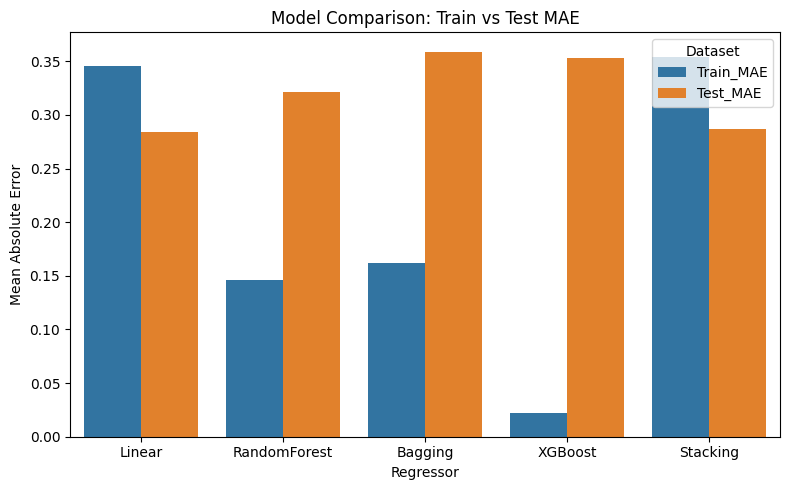

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error

models = {
    "Linear": linear_regressor,
    "RandomForest": random_forest_regressor,
    "Bagging": bagging_regressor,
    "XGBoost": xgboost_regressor,
    "Stacking": stacking_regressor,
}

results = []

for name, model in models.items():
    y_pred_train = model.predict(x_train)
    y_pred_test = model.predict(x_test)

    train_mae = mean_absolute_error(y_train, y_pred_train)
    test_mae = mean_absolute_error(y_test, y_pred_test)

    results.append({"Model": name, "Train_MAE": train_mae, "Test_MAE": test_mae})

mae_df = pd.DataFrame(results).set_index("Model")

# Assuming mae_df from before
mae_df_reset = mae_df.reset_index().melt(
    id_vars="Model",
    value_vars=["Train_MAE", "Test_MAE"],
    var_name="Dataset",
    value_name="MAE",
)

plt.figure(figsize=(8, 5))
sns.barplot(data=mae_df_reset, x="Model", y="MAE", hue="Dataset")
plt.title("Model Comparison: Train vs Test MAE")
plt.ylabel("Mean Absolute Error")
plt.xlabel("Regressor")
plt.legend(title="Dataset")
plt.tight_layout()
plt.show()


### Question 11
`Linear`: Simply calculates the weights for each feature, by minimizing the squared error between predicted and actual values. The fitted model is a straight line generated by a function like y = a + w_1\*x_1 + w_2\*x_2 + w_3\*x_3 + ...

`RandomForest`: Builds multiple decision trees on randomly generated subsets of the original dataset. The final output is the average output of every tree in the random forest.

`Bagging`: Bagging is a technique where multiple models are trained on randomly generated subsets  with replacement. Finally, multiple models generate an output and the final output is calculated with majority voting from the generated models. 

`XGBoost`: XGBoost uses gradient descent to build trees that aim to correct the errors of previous trees. For example, if the initial tree struggles to have good performance on a specific subset, the next trained tree is expected to be trained heavily on that subset and as a result show better performance.

`Stacking`: Stacking uses base models and afterwards uses another model to aggregate the base models results.

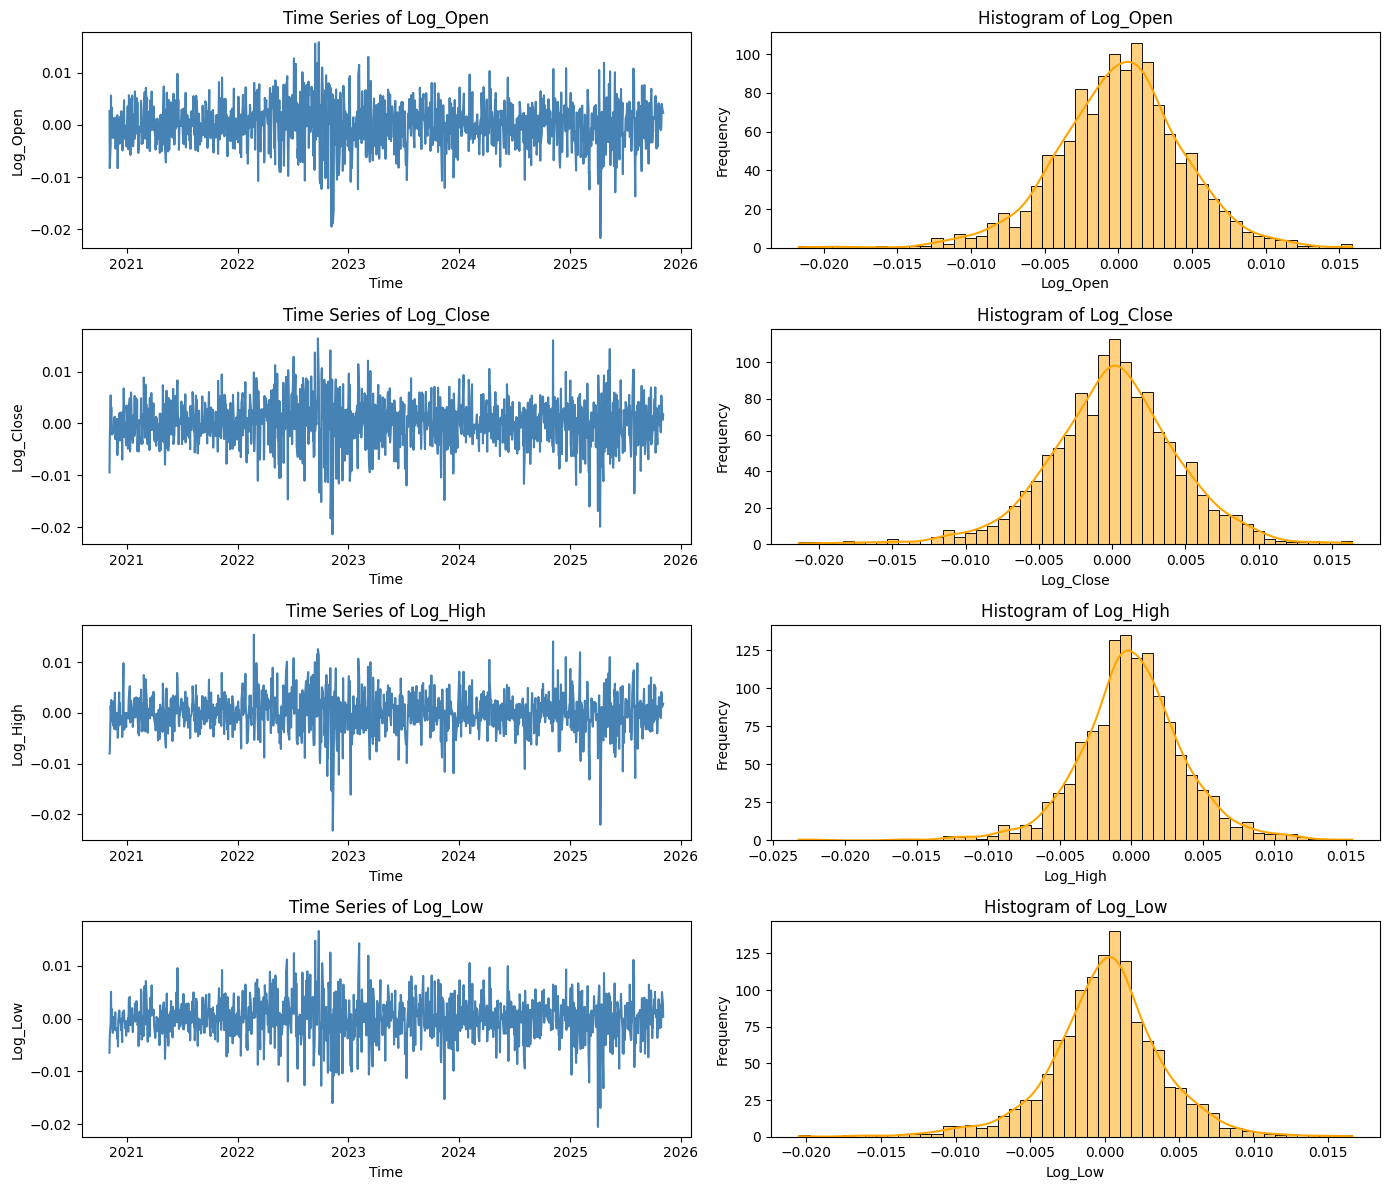

In [17]:
# Logarithmic return calculations
df["Day"] = df.index.day
df["Month"] = df.index.month
df["Log_Open"] = np.log(1 + df["Open"].pct_change())
df["Log_Close"] = np.log(1 + df["Close"].pct_change())
df["Log_High"] = np.log(1 + df["High"].pct_change())
df["Log_Low"] = np.log(1 + df["Low"].pct_change())

log_cols = ["Log_Open", "Log_Close", "Log_High", "Log_Low"]

plt.figure(figsize=(14, 12))

for i, col in enumerate(log_cols, 1):
    # Line plot (time series)
    plt.subplot(4, 2, 2 * i - 1)
    plt.plot(df.index, df[col], color="steelblue")
    plt.title(f"Time Series of {col}")
    plt.xlabel("Time")
    plt.ylabel(col)

    # Histogram
    plt.subplot(4, 2, 2 * i)
    sns.histplot(df[col].dropna(), bins=50, kde=True, color="orange")
    plt.title(f"Histogram of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


### Question 12(a)
The inclusion of day or month in the train set, might help the regressors since it will bring additional information that might be related to specific patterns observed on certain days or certain months. For example, if USD price goes up in the summer (dummy example) the incorporation of months into the dataset will 'reveal' to the models that on months June, July, August the price usually shows an upward trend. 

### Question 12(c)
After the application of the Log Returns formula we see that our 4 features show normal distribution and the non-stationary behavior of the timeseries has been removed. Therefore, it will be easier for the models to make predictions, since the trends and possible seasonalities have been removed from the data.

### Question 12(d)
Before answering this, we need to transform the formula and have y_t+1 on the left hand side. The formula now is y_t+1=y_t\*e^(log_return_y). By solving this we get:

y_t = 0.95, log_return_y=0.01 -> y_t+1 = 0.95*\e^(0.01) = 0.9595. The closing price of the next day is expected to rise almost by 1%.

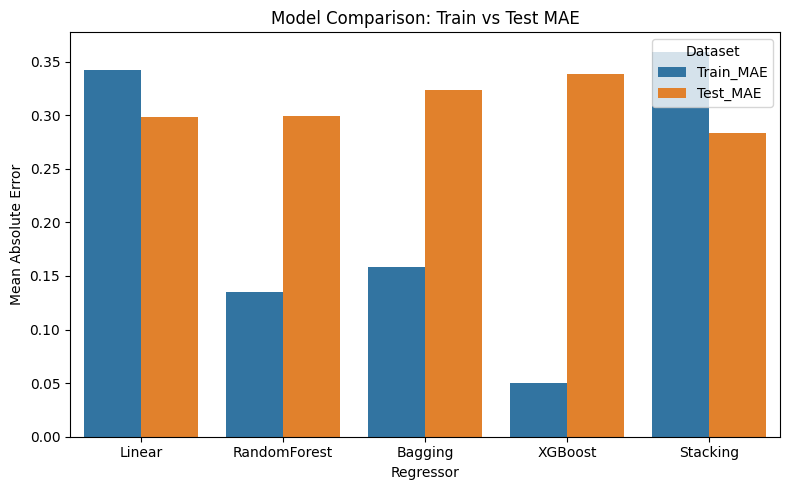

In [18]:
x_train_log, y_train_log = custom_split(
    df.loc[train_index][
        ["Log_Open", "Log_Close", "Log_High", "Log_Low", "Day", "Month"]
    ],
    5,
    "Log_Close",
)
# Ignore first day to avoid Nans, copy values of second day
x_train_log[0][0][:4] = x_train_log[0][1][:4]
x_train_log = x_train_log.reshape(
    x_train_log.shape[0], x_train_log.shape[1] * x_train_log.shape[2]
)

x_test_log, y_test_log = custom_split(
    df.loc[test_index][
        ["Log_Open", "Log_Close", "Log_High", "Log_Low", "Day", "Month"]
    ],
    5,
    "Log_Close",
)
x_test_log = x_test_log.reshape(
    x_test_log.shape[0], x_test_log.shape[1] * x_test_log.shape[2]
)

y_train_shifted = np.empty_like(y_train, dtype=float)
# Duplicate first value for simplicity
y_train_shifted[:] = y_train[0]
y_train_shifted[1:] = y_train[:-1]

y_test_shifted = np.empty_like(y_test, dtype=float)
# Duplicate first value for simplicity
y_test_shifted[:] = y_test[0]
y_test_shifted[1:] = y_test[:-1]

linear_regressor = LinearRegression().fit(x_train_log, y_train_log)
random_forest_regressor = RandomForestRegressor(random_state=0).fit(
    x_train_log, y_train_log
)
bagging_regressor = BaggingRegressor(random_state=0).fit(x_train_log, y_train_log)
xgboost_regressor = XGBRegressor(random_state=0).fit(x_train_log, y_train_log)
estimators = [
    ("linear", LinearRegression()),
    ("tree", DecisionTreeRegressor(random_state=0)),
]
stacking_regressor = StackingRegressor(
    estimators=estimators, final_estimator=LinearRegression()
).fit(x_train_log, y_train_log)

models = {
    "Linear": linear_regressor,
    "RandomForest": random_forest_regressor,
    "Bagging": bagging_regressor,
    "XGBoost": xgboost_regressor,
    "Stacking": stacking_regressor,
}

results = []

for name, model in models.items():
    y_pred_train_log = model.predict(x_train_log)
    y_pred_test_log = model.predict(x_test_log)

    # Predicted prices
    y_pred_train_price = y_train_shifted * np.exp(y_pred_train_log)
    y_pred_test_price = y_test_shifted * np.exp(y_pred_test_log)

    train_mae = mean_absolute_error(y_train, y_pred_train_price)
    test_mae = mean_absolute_error(y_test, y_pred_test_price)

    results.append({"Model": name, "Train_MAE": train_mae, "Test_MAE": test_mae})

mae_df = pd.DataFrame(results).set_index("Model")


# Assuming mae_df from before
mae_df_reset = mae_df.reset_index().melt(
    id_vars="Model",
    value_vars=["Train_MAE", "Test_MAE"],
    var_name="Dataset",
    value_name="MAE",
)

plt.figure(figsize=(8, 5))
sns.barplot(data=mae_df_reset, x="Model", y="MAE", hue="Dataset")
plt.title("Model Comparison: Train vs Test MAE")
plt.ylabel("Mean Absolute Error")
plt.xlabel("Regressor")
plt.legend(title="Dataset")
plt.tight_layout()
plt.show()


In [19]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(
    rows=1,
    cols=1,
)

fig.add_trace(
    go.Scatter(
        x=train_index,
        y=df.loc[train_index]["Close"],
        mode="lines",
        name="Train Data (Real)",
        showlegend=True,
    ),
    row=1,
    col=1,
)

fig.add_trace(
    go.Scatter(
        x=test_index,
        y=y_test,
        mode="lines",
        name="Test Data (Real)",
        showlegend=True,
    ),
    row=1,
    col=1,
)

fig.add_trace(
    go.Scatter(
        x=test_index,
        y=y_pred_test_price,
        name="Test Data (Prediction)",
        mode="lines",
        showlegend=True,
    ),
    row=1,
    col=1,
)


fig.update_layout(
    title_text="Closing Price: Train, Test, Prediction",
    xaxis_title="Date",
    yaxis_title="Price",
)

fig.show()


### Comment
We observe a common issue in timeseries prediction. The predictions seem to be a 'shift' of the previous close value.